In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages
---

In [ ]:
'''
import modules
  - Basic tool
  - DL tool
  - OS tool
'''
# Basic tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DL tools
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# OS tool
import os

# Device Setting
---

In [ ]:
'''
  Setting
    - Path setting to the current directory
    - GPU device setting (device: cuda)
'''

'''
# 뒤에 Model save&load를 위해 작업 directory를 my_PATH로 정의하였습니다.

# Path
my_PATH = "/content/drive/MyDrive/MLP_Assignment"
os.chdir(my_PATH)
# show file list in the current directory
!dir

'''

'''
 (!!!!!!!!!!!!!!중요!!!!!!!!!!!!!!!!)
 GPU 설정을 해줘야 더 효율적인 학습이 가능합니다.
 "device: cuda"로 출력되면 Good!
 "device: cpu"일 경우 현재 코랩에서'런타임 → 런타임 유형 변경 → GPU' 설정을 해줍시다.
 코랩이 기본제공하는 GPU는 하루 최대 12시간 사용 가능합니다. 런타임이 연결되는 동안 시간이 차감됩니다.
 만약 코랩이 기본제공하는 GPU를 다 썼다면 약 하루를 기다리거나 다른 구글계정을 이용해야 합니다.
'''
# Device setting & configuration
# cuda가 available하면 cuda(GPU)로 아니면 CPU 연결
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


# Data Load
---

In [ ]:
'''
  Load MNIST Data
    - Train & Validation & Test data
    - Image and Label
    - Min-Max scaling
'''
# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Min-Max scaling (표준화 과정)
x_train = x_train/255.0
x_test = x_test/255.0

'''
 train_test_split은 sklearn으로 import한 모듈입니다.
 train_test_split을 통해 쉽게 데이터를 분리할 수 있습니다.
 이 코드는 train데이터를 0.8 : 0.2로 train과 validation 데이터로 분리하는 코드입니다,
 print 결과 Train 데이터는 28x28 사이즈의 이미지 데이터가 48,000장 있으며 이미지에 대응하는 label이 48,000개 존재함을 알 수 있습니다.
'''
# Split train data into Train/Validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle=True)

# Check data shape
print(f"Train 데이터 크기: {x_train.shape, y_train.shape}")
print(f"Validation 데이터 크기: {x_val.shape, y_val.shape}")
print(f"Test 데이터 크기:{x_test.shape, y_test.shape}")


11490434/11490434 [==============================] - 1s 0us/step
Train 데이터 크기: ((48000, 28, 28), (48000,))
Validation 데이터 크기: ((12000, 28, 28), (12000,))
Test 데이터 크기:((10000, 28, 28), (10000,))


첫번째 이미지 라벨: 6 
두번째 이미지 라벨: 7 


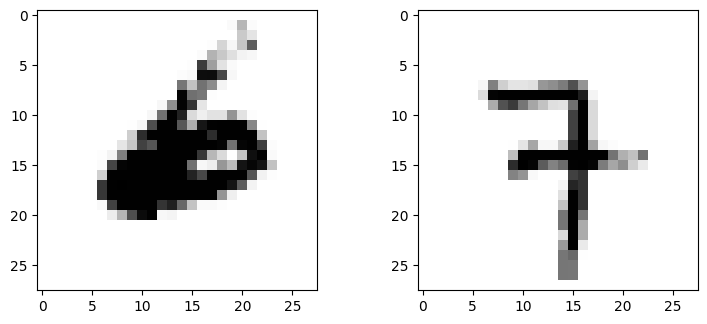

In [ ]:
# Check
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(211)
img1 = plt.imshow(x_train[0].reshape(28, 28)).set_cmap('Greys')
ax2 = fig.add_subplot(222)
img2 = plt.imshow(x_train[1].reshape(28, 28)).set_cmap('Greys')
print(f"첫번째 이미지 라벨: {y_train[0]} ")
print(f"두번째 이미지 라벨: {y_train[1]} ")

In [ ]:
'''
  Data Preparation
    - No augmentation
    - Min-Max scaling (already done at the first)
    - Label(target) -> One hot encoding

    MyDataset은 현재 데이터 set에 다음 속성들을 부여합니다.
    Pytorch의 DataLoader를 활용하기 위해 필요합니다.
'''

class Mydataset(torch.utils.data.Dataset):

    # 데이터 전처리
    def __init__(self, dataX_np , dataY_np):
        self.data_X = dataX_np.astype(np.float32)
        self.data_Y = dataY_np.astype(np.float32)

        print(f"My_dataset __init__ received : {self.data_X.shape}, {self.data_Y.shape} ")

    # 인덱스를 입력받아 인덱스에 알맞는 입출력 데이터를 출력
    def __getitem__(self, index):
        image = self.data_X[index]
        label = self.data_Y[index]
        # One hot encoding
        # 0~9 숫자로 되어있는 라벨을 one hot encoding 형식으로 변환합니다. 이는 이후 MLP의 출력이 10차원이기에 Loss를 계산하기 위해 진행하였습니다.
        label = to_categorical(label, num_classes = 10)

        return image, label

    # 총 데이터 개수를 Return
    def __len__(self):
        return len(self.data_X)

In [ ]:
'''
 DataLoader는 데이터를 batch_size에 맞게 나눠주거나 shuffle해 주는 등의 기능을 지원합니다.
 DataLoader는 데이터를 index로 접근가능하도록 하고 for문에서 사용할 수 있는 iterable 객체로 감싸줍니다.

 batch_size 변수는 train 데이터의 batch 크기를 결정합니다.
 batch_size를 1로 할 경우 SGD가 되며 (모든 데이터의 배치크기가 1이므로 배치 = 하나의 데이터이기 때문입니다)
 batch_size를 현재 데이터의 수보다 같거나 크게 할 경우 BGD가 됩니다. (배치하나가 모든 데이터를 포함하기 때문입니다.)
 현재 batch_size를 32로 설정하였기에 48000//32 = 1500. 1500개의 배치가 생성되며 배치 한개당 32개의 이미지데이터와 라벨데이터가 존재합니다.
 drop_last = False로 설정하여 배치로 나눴을 때 32개가 채워지지 못하는 마지막 배치를 그대로 살리도록 하였습니다.

 train_loader의 경우 batch_size=32로 설정하여 Mini-batch Gradient Descent를 사용하도록 하였습니다.
 valid_lodaer와 test_loader의 batch_size를 데이터의 수보다 크게하여 모든 데이터에 대한 Loss와 Accuracy가 구해질 수 있도록 하였습니다.

 x_train, x_val, x_test 모두 (-1,28*28)로 reshape하였습니다. 즉, 28x28의 크기로 이뤄진 이미지 데이터를 28*28 = 784 차원의 벡터로 Flatten하였습니다.
 이미지 데이터를 일자로 폈다고 생각하시면 됩니다. 따라서 MLP 모델에 입력되는 데이터는 784차원의 벡터입니다.
'''

batch_size = 32
train_loader = torch.utils.data.DataLoader(Mydataset(x_train.reshape(-1,28*28), y_train), batch_size=batch_size, shuffle=False, drop_last = False)
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val.reshape(-1,28*28), y_val), batch_size = 1000000000, shuffle=False, drop_last = False)
test_loader = torch.utils.data.DataLoader(Mydataset(x_test.reshape(-1,28*28), y_test), batch_size = 100000000, shuffle=False, drop_last = False)

My_dataset __init__ received : (48000, 784), (48000,) 
My_dataset __init__ received : (12000, 784), (12000,) 
My_dataset __init__ received : (10000, 784), (10000,) 


# MLP Model
---

In [ ]:
'''
  MLP 모델을 정의하는 Class 입니다.

  self.fc1 에서 fc1은 layer의 이름이며 fc1을 nn.Linear(input_dimension, output_dimension, bias=False)로 정의할 수 있습니다.
  즉 fc1은 784차원의 input을 wx+b의 Linear 함수를 적용하여 2048차원으로 보냅니다.(input 뉴런 784개, output 뉴런 2048개로 이뤄진 두 layer를 연결합니다.)
  bias를 True로 설정할 경우 bias를 추가할 수 있습니다.

'''
class MLP_overfit(nn.Module):
    def __init__(self):
        super(MLP_overfit, self).__init__()
        self.fc1 = nn.Linear(784, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512,256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)

        # Pytorch에서는 Softmax가 CrossEntropy함수안에 내장되어 있기에 없어도 됩니다.
        # 이후 Loss를 CrossEntropy를 사용할 것이기에 제외하였습니다.
        # x = F.log_softmax(x, dim=1)

        return x

In [21]:
class MLP_underfit(nn.Module):
    def __init__(self):
        super(MLP_underfit, self).__init__()
        self.fc1 = nn.Linear(784, 4)
        self.fc2 = nn.Linear(4, 10)
        self.fc3 = nn.Linear(10, 32)
        self.fc4 = nn.Linear(32, 64)
        self.fc5 = nn.Linear(64, 128)
        self.fc6 = nn.Linear(128, 10)
        #과제 1에서 수정 또는 채워주셔야 할 부분입니다!

        # Weight Initialization
        torch.nn.init.xavier_normal_(self.fc1.weight.data, gain=1.0)
        torch.nn.init.xavier_normal_(self.fc2.weight.data, gain=1.0)
        torch.nn.init.xavier_normal_(self.fc3.weight.data, gain=1.0)
        torch.nn.init.xavier_normal_(self.fc4.weight.data, gain=1.0)
        torch.nn.init.xavier_normal_(self.fc5.weight.data, gain=1.0)
        torch.nn.init.xavier_normal_(self.fc6.weight.data, gain=1.0)


    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)

        # 과제 1에서 채워주셔야 할 부분입니다!
        return x

# Train
---

In [ ]:
from statistics import mean
import time

'''
 모델의 학습을 정의하는 함수입니다.
 model, Lossfunction, Optimizer, Scheduler 등을 입력받습니다.
 출력은 train, validation, test의 loss 리스트로 하였습니다.
 train함수를 사용하면 입력받은 loss와 optimizer, lr scheduler, num_epoch에 따라 model을 학습시킵니다.
'''

def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):

    train_losses = []
    valid_losses = []
    test_losses = []

    print("----------------------------------------------------------------------------")

    start_time = time.time()
    for epoch in range(first_epoch, first_epoch + num_epochs):
        # train phase
        model.train()

        # batch_loss
        batch_losses = []

        for images, labels in train_loader:

            # Move the training data to the GPU
            images = images.to(device)
            labels = labels.to(device)

            # clear previous gradient computation
            optimizer_.zero_grad()

            # forward propagation
            outputs = model(images)

            # calculate the loss
            loss = criterion_.forward(outputs, labels)
            batch_losses.append(loss.item())

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer_.step()

        # Train loss를 저장합니다.
        train_losses.append(mean(batch_losses))

        # validation phase
        # Dropout, BatchNormalization과 같은 layer가 동작하지 않도록 합니다.
        model.eval()

        # We don't need gradients for test, so wrap in
        # no_grad to save memory
        # 기울기 Gradient를 계산하지 않으며 backpropagation을 하지 않습니다.
        with torch.no_grad():

            correct_test = 0

            for images, labels in valid_loader:

                # Move the training batch to the GPU
                images = images.to(device)
                labels = labels.to(device)

                # forward propagation
                outputs = model(images)

                # calculate the loss
                loss = criterion_(outputs, labels)
                valid_losses.append(loss.item())

            for images, labels in test_loader:
                # Move the training batch to the GPU
                images = images.to(device)
                labels = labels.to(device)

                # forward propagation
                outputs = model(images)

                # calculate the loss
                loss = criterion_(outputs, labels)
                test_losses.append(loss.item())

                # Check Accuracy
                # preds 는 output 중에서 가장 높은 값의 index를 가집니다.
                _, preds = torch.max(outputs, 1)

                # label이 현재 one hot encoding 형태로 되어있기에 preds를 index로 받아 1인지 확인합니다.
                # ex) 숫자 2 : label = [0,0,1,0,0,...,0] , label[i][preds] == 1 -> 정답
                for i in range(len(preds)):
                  if labels[i][preds[i]] == 1:
                    correct_test +=1

        # 원하는 Epoch마다 결과 출력
        if (epoch) % 1== 0 :
            curr_time = round(time.time()-start_time)
            train_rec = round(train_losses[-1],5)
            valid_rec = round(valid_losses[-1],5)
            test_rec = round(test_losses[-1],5)
            test_acc = round(100*(correct_test)/len(labels),3)
            print('Epoch', epoch, ' / ',num_epochs)
            print(f"\t [Train loss : {train_rec}]  [Validation loss : {valid_rec}] [Test loss : {test_rec}], [Test Accuracy : {test_acc}%],[curr LR = {scheduler_.get_last_lr()}],[elapsed_time = {curr_time}sec] ")

        # Learning rate Scheduling
        # Scheduler에 따라 learning rate를 조절합니다.
        scheduler_.step()


    print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")
    print("--------------------------------------------------------------------")

    # Loss 값 반환
    return train_losses, valid_losses, test_losses

## Setting

In [ ]:
# Model Setting
model = MLP_overfit()
model.to(device)

# Optimizer
# Optimzer와 Learning rate를 설정해줍니다. 과제1과 관련된 부분입니다!
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
# epoch가 10번 돌때마다 learning rate를 gamma만큼 곱해 사용합니다. ex) 0.01 -> 0.005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

## Training

### Overfitting

In [ ]:
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=35)

----------------------------------------------------------------------------
Epoch 1  /  35
	 [Train loss : 2.30132]  [Validation loss : 2.30026] [Test loss : 2.29949], [Test Accuracy : 11.35%],[curr LR = [0.01]],[elapsed_time = 25sec] 
Epoch 2  /  35
	 [Train loss : 2.29794]  [Validation loss : 2.296] [Test loss : 2.29518], [Test Accuracy : 11.35%],[curr LR = [0.01]],[elapsed_time = 51sec] 
Epoch 3  /  35
	 [Train loss : 2.28143]  [Validation loss : 2.23736] [Test loss : 2.23511], [Test Accuracy : 21.1%],[curr LR = [0.01]],[elapsed_time = 71sec] 
Epoch 4  /  35
	 [Train loss : 1.66137]  [Validation loss : 0.87792] [Test loss : 0.86892], [Test Accuracy : 70.81%],[curr LR = [0.01]],[elapsed_time = 91sec] 
Epoch 5  /  35
	 [Train loss : 0.65596]  [Validation loss : 0.44558] [Test loss : 0.44028], [Test Accuracy : 87.94%],[curr LR = [0.01]],[elapsed_time = 116sec] 
Epoch 6  /  35
	 [Train loss : 0.37519]  [Validation loss : 0.29818] [Test loss : 0.29935], [Test Accuracy : 92.11%],[curr LR

### Underfitting

In [22]:
# Moodel Setting
model = MLP_underfit()
model.to(device)

# Optimizer
# Optimzer와 Learning rate를 설정해줍니다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
# epoch가 10번 돌때마다 learning rate를 gamma만큼 곱해 사용합니다. ex) 0.01 -> 0.005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [23]:
train_losses_2, valid_losses_2, test_losses_2 = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=10)

----------------------------------------------------------------------------
Epoch 1  /  10
	 [Train loss : 0.75121]  [Validation loss : 0.50741] [Test loss : 0.49374], [Test Accuracy : 84.27%],[curr LR = [0.001]],[elapsed_time = 21sec] 
Epoch 2  /  10
	 [Train loss : 0.46854]  [Validation loss : 0.43999] [Test loss : 0.42831], [Test Accuracy : 86.35%],[curr LR = [0.001]],[elapsed_time = 48sec] 
Epoch 3  /  10
	 [Train loss : 0.42916]  [Validation loss : 0.41974] [Test loss : 0.40879], [Test Accuracy : 86.99%],[curr LR = [0.001]],[elapsed_time = 67sec] 
Epoch 4  /  10
	 [Train loss : 0.40973]  [Validation loss : 0.408] [Test loss : 0.39956], [Test Accuracy : 87.3%],[curr LR = [0.001]],[elapsed_time = 84sec] 
Epoch 5  /  10
	 [Train loss : 0.39707]  [Validation loss : 0.40341] [Test loss : 0.39615], [Test Accuracy : 87.38%],[curr LR = [0.001]],[elapsed_time = 104sec] 
Epoch 6  /  10
	 [Train loss : 0.38802]  [Validation loss : 0.40175] [Test loss : 0.39387], [Test Accuracy : 87.47%],[cu

# Plot Result
---

In [24]:
def plot_result(train_loss, val_loss, test_loss):
  plt.figure(figsize=(20,8))
  plt.plot(train_loss, label='Train Loss', linewidth='3')
  plt.plot(val_loss, label='Validation Loss', linewidth='3')
  plt.plot(test_loss, label='Test Loss', linewidth='3')
  plt.grid()
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)
  plt.legend()
  plt.rc('legend', fontsize=15)
  plt.xlabel('Number of Epoch')
  plt.ylabel('Cross Entropy Loss')
  plt.rc('axes', labelsize=17)


#### Overfitting graph

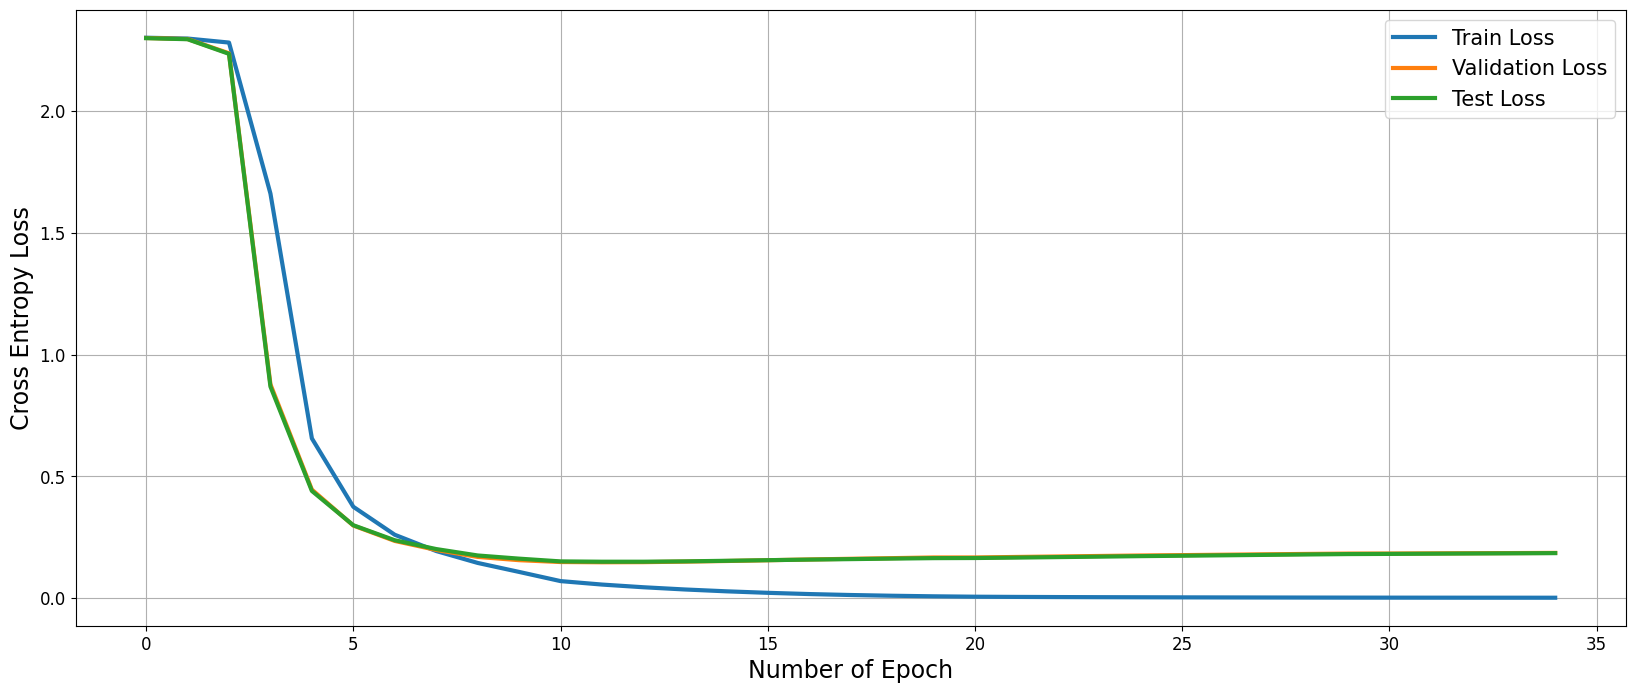

In [25]:
plot_result(train_losses, valid_losses, test_losses)

#### Underfitting graph

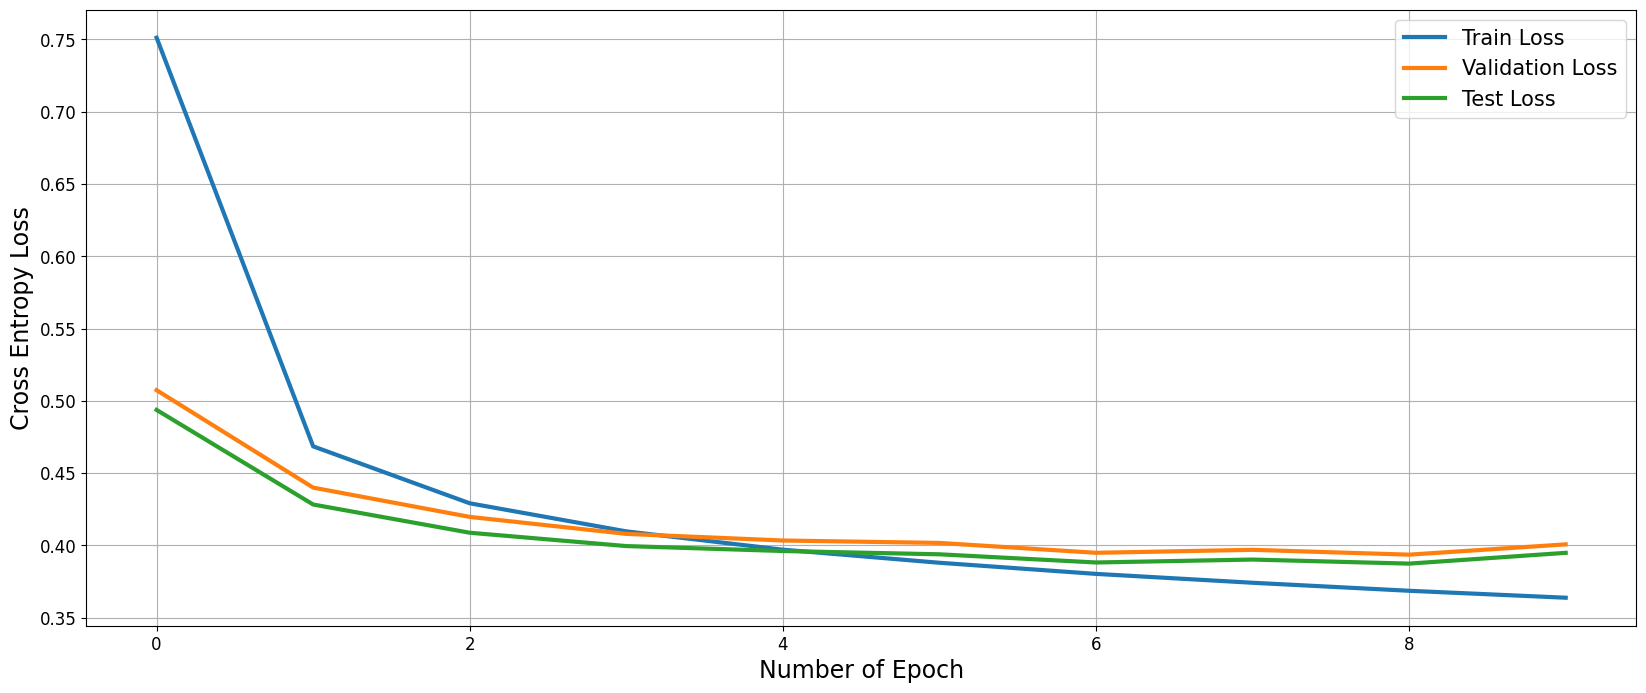

In [26]:
plot_result(train_losses_2, valid_losses_2, test_losses_2)

* 최적점을 기준으로 좌측이 underfitting이 일어나는 구간이며, 우측이 overfitting이 일어나는 구간이다.

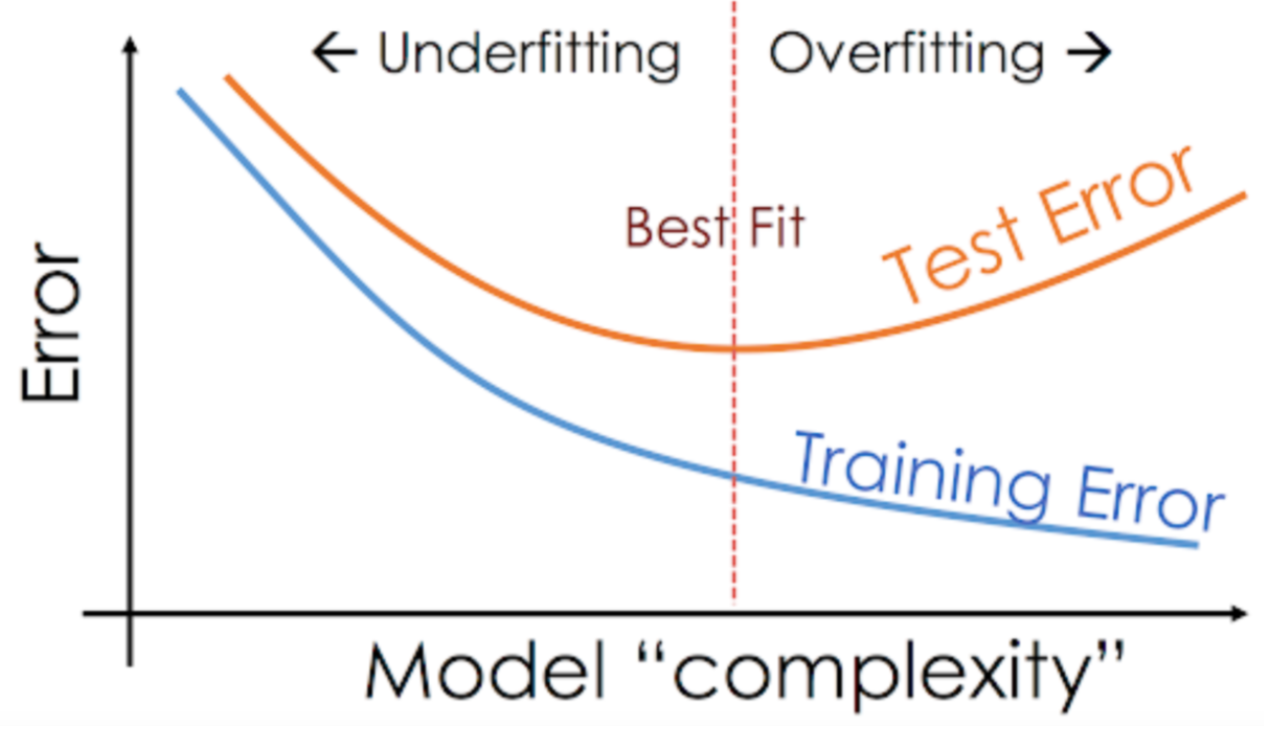

# Model Save & Load (참고용)
---

In [ ]:
'''
  Modle Save & Load
'''
def save_model_info(model,model_name="ver_1", train_losses=train_losses, valid_losses=valid_losses, test_losses=test_losses):

    if not os.path.isdir("./models"):
        os.makedirs("./models")
    # 모델 정보 저장
    torch.save({'model_state_dict': model.state_dict(),
                'record_list' : [train_losses, valid_losses, test_losses]
                }, f"./models/model_{model_name}.pth")

    print(f"model_saved : model_{model_name}")


def load_model_info(model_name="ver_1"):

    file_path = f"./models/model_{model_name}.pth"


    if not os.path.exists(file_path):
        print("FATAL ERROR : model path not exist")
    model_info = torch.load(file_path)
    print(f"model_loaded : model_{model_name}")

    model = MLP_underfit()
    model.load_state_dict(model_info['model_state_dict'])
    model.to(device)
    model.eval()

    return model

In [ ]:
save_model_info(model, "underfit", train_losses, valid_losses, test_losses)

In [ ]:
model = load_model_info("underfit")

# Generalized MLP

In [ ]:
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=40)

In [ ]:
plot_result(train_losses, valid_losses, test_losses)

Thanks to 21기 DS팀 이영환